In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
#1. Định nghĩa mô hình MobileFaceNet

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel=3, stride=1, padding=1, groups=1, activation=True):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.prelu = nn.PReLU(out_c) if activation else nn.Identity()

    def forward(self, x):
        return self.prelu(self.bn(self.conv(x)))

class LinearBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel=3, stride=1, padding=1, groups=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_c)

    def forward(self, x):
        return self.bn(self.conv(x))

class Bottleneck(nn.Module):
    def __init__(self, in_c, out_c, stride, expansion):
        super().__init__()
        self.stride = stride
        mid_c = in_c * expansion
        self.use_res_connect = (self.stride == 1 and in_c == out_c)

        self.conv = nn.Sequential(
            ConvBlock(in_c, mid_c, kernel=1, stride=1, padding=0),
            ConvBlock(mid_c, mid_c, kernel=3, stride=stride, padding=1, groups=mid_c),
            LinearBlock(mid_c, out_c, kernel=1, stride=1, padding=0)
        )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            return x + out
        else:
            return out

class GlobalDepthwiseConv(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.gdconv = nn.Conv2d(in_c, in_c, kernel_size=7, groups=in_c, bias=False)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        x = self.gdconv(x)
        x = self.bn(x)
        return x

class MobileFaceNet(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.conv1 = ConvBlock(3, 64, kernel=3, stride=2, padding=1)  # 112->56
        self.bottlenecks = nn.Sequential(
            Bottleneck(64, 64, 1, 2),
            Bottleneck(64, 64, 2, 2),  # 56->28
            Bottleneck(64, 128, 1, 4),
            Bottleneck(128, 128, 2, 2),  # 28->14
            Bottleneck(128, 128, 1, 4),
            Bottleneck(128, 128, 2, 2),  # 14->7
            Bottleneck(128, 128, 1, 4)
        )
        self.conv2 = ConvBlock(128, 512, kernel=1, stride=1, padding=0)
        self.gdconv = GlobalDepthwiseConv(512)
        self.linear = nn.Conv2d(512, embedding_size, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(embedding_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bottlenecks(x)
        x = self.conv2(x)
        x = self.gdconv(x)
        x = self.linear(x)
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        return F.normalize(x)


In [3]:
# 2. Chuẩn bị dữ liệu

transform_train = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Thay 'dataset/train' bằng đường dẫn tới thư mục dữ liệu của bạn
train_dataset = datasets.ImageFolder(root='/kaggle/input/vnface-traindata/train_data', transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

print(f"Số lượng lớp: {len(train_dataset.classes)}")


Số lượng lớp: 991


In [4]:
transform_val = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_dataset = datasets.ImageFolder(root='/kaggle/input/val-data/val', transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Số lượng lớp val: {len(val_dataset.classes)}")

Số lượng lớp val: 150


In [5]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, classnum, s=64.0, m=0.5):
        super().__init__()
        self.classnum = classnum
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(classnum, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        weight_norm = F.normalize(self.weight)
        cosine = F.linear(F.normalize(embeddings), weight_norm)
        theta = torch.acos(torch.clamp(cosine, -1.0+1e-7, 1.0-1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1,1), 1.0)
        output = cosine * (1 - one_hot) + target_logits * one_hot
        output *= self.s
        loss = F.cross_entropy(output, labels)
        return loss

In [6]:
history = {
    'train_loss': [],
    'train_acc': []
}

In [7]:
# 4. Huấn luyện với Mixed Precision (AMP)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileFaceNet(embedding_size=512).to(device)
criterion = ArcFaceLoss(embedding_size=512, classnum=len(train_dataset.classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)
scaler = torch.amp.GradScaler('cuda')

def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            embeddings = model(imgs)
            loss = criterion(embeddings, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        # Tính accuracy
        cos_sim = torch.matmul(F.normalize(embeddings), F.normalize(criterion.weight.t()))
        preds = torch.argmax(cos_sim, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [8]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                embeddings = model(imgs)
                loss = criterion(embeddings, labels)
            total_loss += loss.item()
            cos_sim = torch.matmul(F.normalize(embeddings), F.normalize(criterion.weight.t()))
            preds = torch.argmax(cos_sim, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [9]:
import os
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


checkpoint_dir = './ckpt'
os.makedirs(checkpoint_dir, exist_ok=True)

# Tạo các list để lưu giá trị
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
lr_list = []


scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        
    factor=0.5,         
    patience=10,              
    min_lr=1e-6         
)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Lưu model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch+1:02d}.pth')
    torch.save({'epoch': epoch + 1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),

}, checkpoint_path)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)
    lr_list.append(optimizer.param_groups[0]['lr'])

    # Cập nhật learning rate
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/100, Train Loss: 38.3621, Train Acc: 0.0276, Val Loss: 39.4539, Val Acc: 0.0014
Epoch 2/100, Train Loss: 36.5642, Train Acc: 0.1045, Val Loss: 39.9038, Val Acc: 0.0028
Epoch 3/100, Train Loss: 35.6395, Train Acc: 0.1992, Val Loss: 40.2940, Val Acc: 0.0007
Epoch 4/100, Train Loss: 34.7629, Train Acc: 0.2841, Val Loss: 40.7911, Val Acc: 0.0000
Epoch 5/100, Train Loss: 33.9340, Train Acc: 0.3605, Val Loss: 40.9364, Val Acc: 0.0007
Epoch 6/100, Train Loss: 33.1082, Train Acc: 0.4253, Val Loss: 41.6155, Val Acc: 0.0014
Epoch 7/100, Train Loss: 32.2775, Train Acc: 0.4887, Val Loss: 41.9005, Val Acc: 0.0007
Epoch 8/100, Train Loss: 31.4422, Train Acc: 0.5363, Val Loss: 42.1648, Val Acc: 0.0000
Epoch 9/100, Train Loss: 30.6355, Train Acc: 0.5801, Val Loss: 42.6665, Val Acc: 0.0014
Epoch 10/100, Train Loss: 29.8046, Train Acc: 0.6209, Val Loss: 42.8477, Val Acc: 0.0007
Epoch 11/100, Train Loss: 29.0445, Train Acc: 0.6560, Val Loss: 42.9933, Val Acc: 0.0007
Epoch 12/100, Train Loss: 28.3

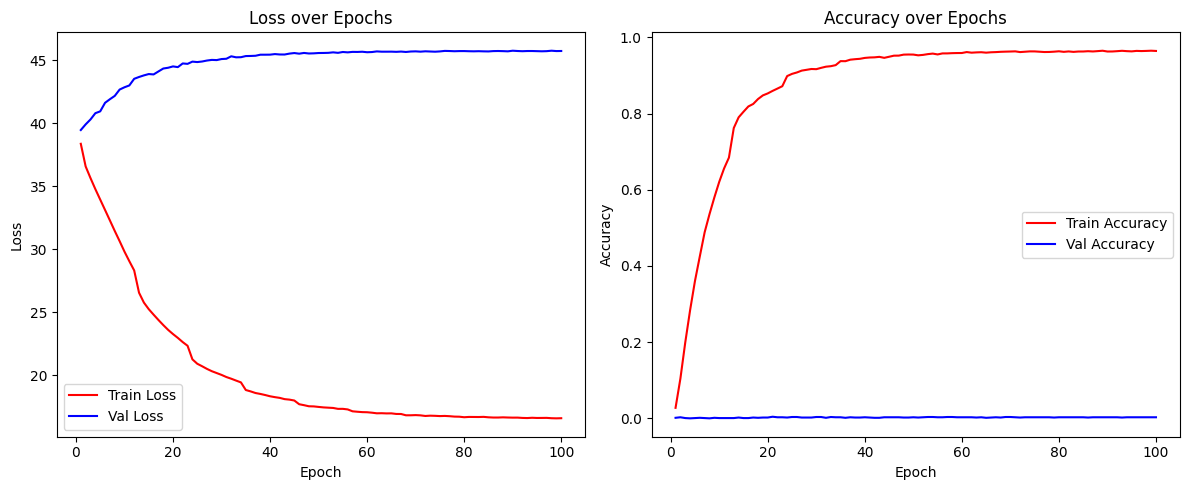

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, 'r-', label='Train Loss')
plt.plot(epochs, val_loss_list, 'b-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, 'r-', label='Train Accuracy')
plt.plot(epochs, val_accuracy_list, 'b-', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# # Load lại checkpoint
# checkpoint = torch.load('./ckpt/epoch_100.pth', map_location='cpu')
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# dummy_input = torch.randn(1, 3, 112, 112).to(device)  # Match device với model
# torch.onnx.export(
#     model,
#     dummy_input,
#     "model.onnx",
#     input_names=["input"],
#     output_names=["output"],
#     opset_version=11,
#     dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
# )


In [13]:
# import os
# import onnx
# from onnx_tf.backend import prepare
# import tensorflow as tf

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Đường dẫn lưu các file trung gian và cuối cùng
# onnx_path = "mobilefacenet.onnx"
# tf_model_path = "mobilefacenet_tf"
# tflite_path = "mobilefacenet.tflite"

# # 1. Export PyTorch model sang ONNX
# model.eval()
# dummy_input = torch.randn(1, 3, 112, 112).to(device)
# with torch.no_grad():
#     torch.onnx.export(model, dummy_input, onnx_path,
#                       input_names=['input'], output_names=['output'],
#                       opset_version=11, do_constant_folding=True)
# print(f"Đã export model sang ONNX: {onnx_path}")

# # 2. Chuyển ONNX sang TensorFlow SavedModel
# onnx_model = onnx.load(onnx_path)
# tf_rep = prepare(onnx_model)
# if os.path.exists(tf_model_path):
#     import shutil
#     shutil.rmtree(tf_model_path)
# tf_rep.export_graph(tf_model_path)
# print(f"Đã chuyển sang TensorFlow SavedModel tại: {tf_model_path}")

# # 3. Chuyển TensorFlow SavedModel sang TFLite
# converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)

# # Bật tối ưu hóa để thực hiện post-training quantization
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

# with open(tflite_path, 'wb') as f:
#     f.write(tflite_model)
# print(f"Đã lưu model TFLite tại: {tflite_path}")